In [1]:
import warnings; warnings.filterwarnings('ignore')

#from nilmtk.dataset_converters import convert_ukdale
#convert_ukdale('./data/UKDALE', './data/UKDALE/ukdale.h5')  # Skip if we already have the data in .h5 file

In [2]:
from nilmtk import DataSet
train = DataSet('./data/UKDALE/ukdale.h5')
train.set_window(start="13-4-2013", end="1-1-2014") # Training data time window
train_elec = train.buildings[1].elec # Get building 1 meters

In [3]:
from rnndisaggregator import RNNDisaggregator
rnn = RNNDisaggregator()

Using TensorFlow backend.
/home/caim03/anaconda2/envs/nilmtk-env/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:923: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/home/caim03/anaconda2/envs/nilmtk-env/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/caim03/anaconda2/envs/nilmtk-env/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4785: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/caim03/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))


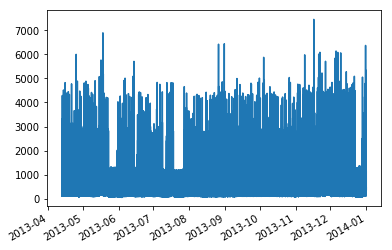

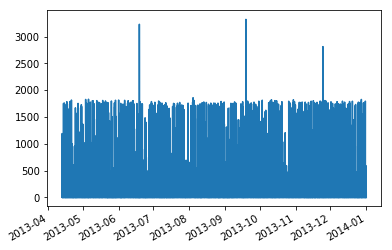

------ TRAINING ------


/home/caim03/anaconda2/envs/nilmtk-env/lib/python3.6/site-packages/nilmtk/utils.py:426: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


Epoch 1/5
3787799/3787799 [==============================] - 877s 231us/step - loss: 4.1361e-05
Epoch 2/5
3787799/3787799 [==============================] - 873s 230us/step - loss: 3.6054e-05
Epoch 3/5
3787799/3787799 [==============================] - 874s 231us/step - loss: 3.5872e-05
Epoch 4/5
3787799/3787799 [==============================] - 874s 231us/step - loss: 3.5805e-05
Epoch 5/5
3787799/3787799 [==============================] - 874s 231us/step - loss: 3.5746e-05


In [4]:
import matplotlib.pyplot as plt

train_mains = train_elec.mains() # The aggregated meter that provides the input
train_meter = train_elec.submeters()['fridge'] # The kettle meter that is used as a training target

plt.figure(1)
train_mains.power_series_all_data().plot()
plt.show()

plt.figure(2)
train_meter.power_series_all_data().plot()
plt.show()

print("------ TRAINING ------")
rnn.train(train_mains, train_meter, epochs=5, sample_period=6)
rnn.export_model("./data/UKDALE/model-ukdale.h5")

In [5]:
test = DataSet('./data/UKDALE/ukdale.h5')
test.set_window(start="1-1-2014", end="30-3-2014")
test_elec = test.buildings[1].elec
test_mains = test_elec.mains()

disag_filename = './data/UKDALE/disag-out.h5' # The filename of the resulting datastore
from nilmtk.datastore import HDFDataStore
output = HDFDataStore(disag_filename, 'w')

print("------ TESTING ------")
rnn.disaggregate(test_mains, output, train_meter, sample_period=6)

------ TESTING ------


/home/caim03/anaconda2/envs/nilmtk-env/lib/python3.6/site-packages/nilmtk/utils.py:426: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


New sensible chunk: 885036
New sensible chunk: 587
New sensible chunk: 574
New sensible chunk: 574
New sensible chunk: 376872


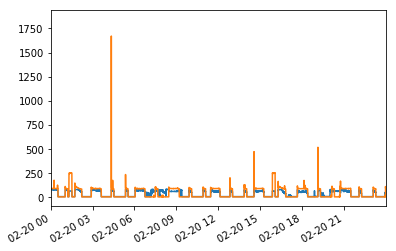

In [6]:
result = DataSet(disag_filename)
res_elec = result.buildings[1].elec
predicted = res_elec['fridge']
ground_truth = test_elec['fridge']

predicted.power_series_all_data().plot()
ground_truth.power_series_all_data().plot()
plt.xlim('2014-02-20 00:00:00', '2014-02-20 23:59:00')
plt.show()

In [7]:
import metrics
print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(predicted, ground_truth)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(predicted, ground_truth)))

/home/caim03/anaconda2/envs/nilmtk-env/lib/python3.6/site-packages/nilmtk/datastore/hdfdatastore.py:128: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  stop=look_ahead_end_i)
/home/caim03/anaconda2/envs/nilmtk-env/lib/python3.6/site-packages/pandas/core/internals.py:2633: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  return self.values.astype('datetime64[ns]').values


============ Relative error in total energy: 0.3203846936066091
============ Mean absolute error(in Watts): 33.530527061349225
